##### Download vol cube data

In [1]:
import sys
sys.path.append('../..')  # to go to the main folder of the whole project

from src.data.vol.get_vol_cube_tenors_strikes_dates import get_vol_cube_tenors_strikes_dates
data, uniq_opt_tenors, uniq_swap_tenors, uniq_strikes, dates = get_vol_cube_tenors_strikes_dates()

# Normalize data
from src.data.vol.normalizer import Normalizer
normalizer = Normalizer()
data_norm = normalizer.normalize(data)

# Split train and test datasets
seed = 0 # other seeds provides the same result
from src.utils.get_train_test_datasets import get_train_test_datasets
data_norm_train, dates_train, data_norm_test, dates_test = get_train_test_datasets(data_norm,
                                                                                   dates,
                                                                                    seed=seed,
                                                                                    train_ratio=0.8)

data_train = normalizer.denormalize(data_norm_train)
data_test = normalizer.denormalize(data_norm_test)

##### Create and train the model (uncomment to run it - it takes 10 minutes to train)

* The model has latent space dimension = 2.

* Beta is a weight of Kullback-Leibler (KL) loss when we calculate total loss as a sum of KL loss and reconstruction loss.

In [2]:
# EPOCHS = 3000
# BATCH_SIZE = 16
# HIDDEN_LAYERS_NODES =  [400, 200, 200, 100]
# LOSS_TYPE = 'mse'  # or 'bce'
# BETA = 2e-6

# # Create the name of the model based on characteristics
# NAME = 'vol_cube_vae_van_2latd_' 
# for i, nodes in enumerate(HIDDEN_LAYERS_NODES):
#     NAME += str(nodes) + '_'
# NAME += str(EPOCHS) + 'ep_bat' + str(BATCH_SIZE) +'_' + str(BETA)
# NAME += '_seed' + str(seed)
# print(NAME)


# # Create VAE and fit it
# from src.models.vae_vanilla import VaeVanilla
# vae = VaeVanilla(input_shape=data_norm_train.shape[1:],
#                  hidden_layers_nodes=HIDDEN_LAYERS_NODES, # best [400, 200, 200, 100] or a bit worse [400, 200, 100, 50]
#                  latent_space_dim=2,
#                  loss_type=LOSS_TYPE,  
#                  beta=BETA)
# vae.compile(optimizer='adam')
# history = vae.fit(data_norm_train, 
#                   epochs=EPOCHS, 
#                   verbose=0,
#                   batch_size=BATCH_SIZE,
#                   validation_data=data_norm_test)  # add validation_data=data_norm_test worse results

##### Save the model

In [ ]:
# from src.utils.save_model_and_history import save_model_and_history
# save_model_and_history(vae, 
#                        history, 
#                        NAME,
#                        data_type='vol')

##### Load the saved model and its history from the file

In [2]:
from src.utils.load_model_and_history import load_model_and_history

NAME = 'vol_cube_vae_van_2latd_400_200_200_100_3000ep_bat16_2e-06_seed0'
vae, history = load_model_and_history(NAME,
                                      data_type='vol')

c:\Users\alexi\Documents\All\ETH_UZH\MasterThesis\_MT_Vol_cube\code_my\autoencoder_library\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


##### Kullback-Leibler loss, Reconstruction loss and Total Losses of trained model

In [3]:
history.history['val_kl_loss'][-1], \
history.history['val_reconstruction_loss'][-1], \
history.history['val_total_loss'][-1]

(1.4983878827479202e-05, 3.9608006773050874e-05, 5.3818101150682196e-05)

##### Plot history of train and test losses against the epochs

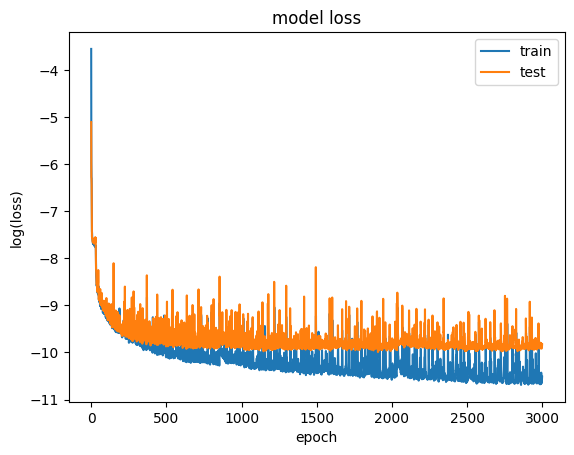

In [5]:
from src.visualization.plot_history_of_losses import plot_history_of_losses
plot_history_of_losses(history)

##### Plot 2d latent space values

For each date, based on vol cube data, we calculate latent space values z0 and z1

It looks similar to the Gaussian distribution - that's why Kullback-Leibner loss is small

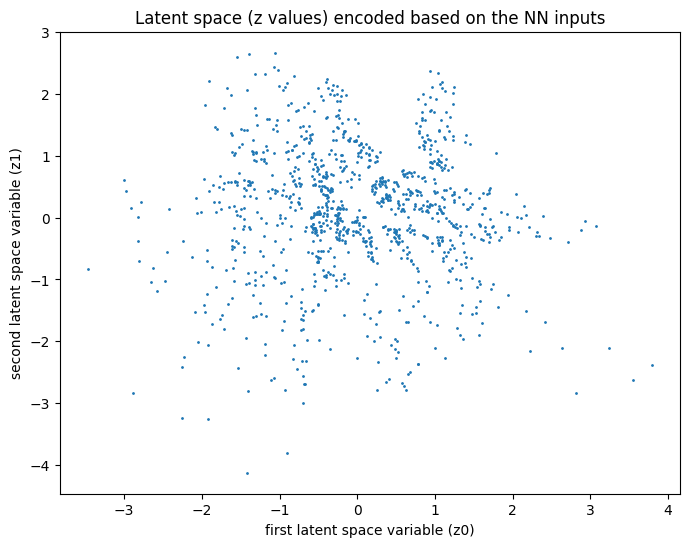

In [6]:
from src.visualization.plot_latent_space_2d_values import plot_latent_space_2d_values
plot_latent_space_2d_values(vae,
                            data_norm_train,
                            vae_latent_type='z',
                            data_type='vol',
                            save_name=NAME)

For each date, based on vol cube data, we calculate ***means*** of latent space values z0 and z1

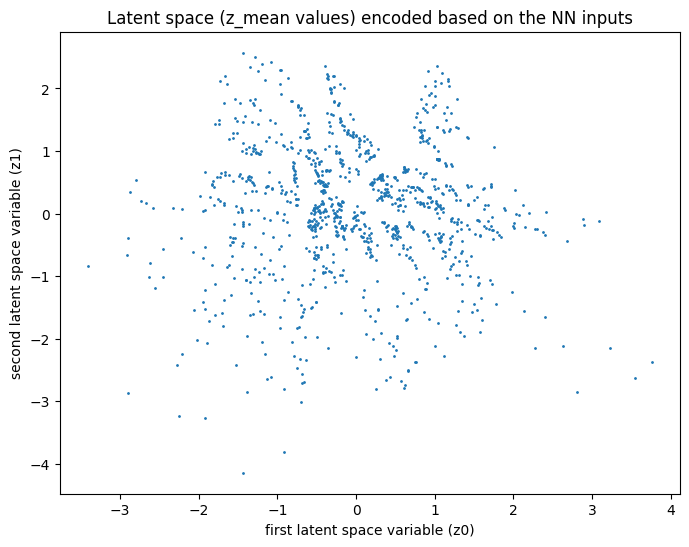

In [7]:
from src.visualization.plot_latent_space_2d_values import plot_latent_space_2d_values
plot_latent_space_2d_values(vae, 
                            data_norm_train,
                            vae_latent_type='z_mean',
                            data_type='vol',
                            save_name=NAME)

For each date, based on vol cube data, we calculate ***log of variance*** of latent space values z0 and z1

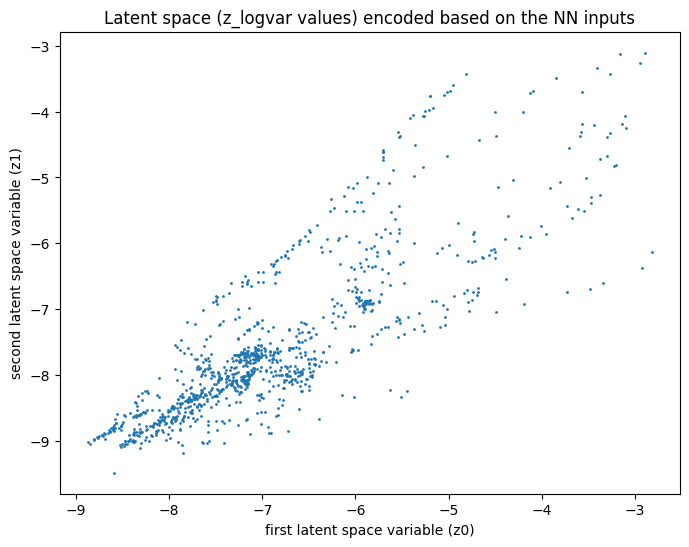

In [8]:
from src.visualization.plot_latent_space_2d_values import plot_latent_space_2d_values
plot_latent_space_2d_values(vae, 
                            data_norm_train,
                            vae_latent_type='z_logvar',
                            data_type='vol',
                            save_name=NAME)

##### Error histograms

Error histogram shows the distribution of errors. Each error is the difference between real volatility value and reconstructed volatility value for a certain data point in volatility cube and a certain date. Mean (and max) is calculated over all dates and data points in vol cube.

##### Error histograms for train dataset:

Mean error 0.9
Max error 34.16


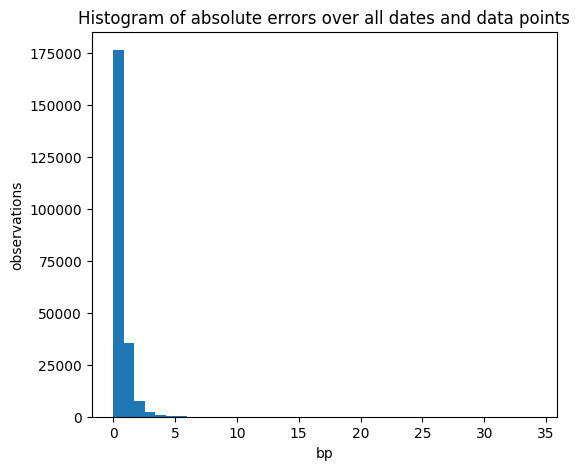

In [4]:
from src.visualization.vol.error_histograms import error_histograms

predictions = normalizer.denormalize(vae.predict(x=data_norm_train, verbose=0))
error_histograms(predictions,
                 data_train,
                 save_name=NAME)

##### Error histograms for test dataset:

Mean error 1.52
Max error 44.74


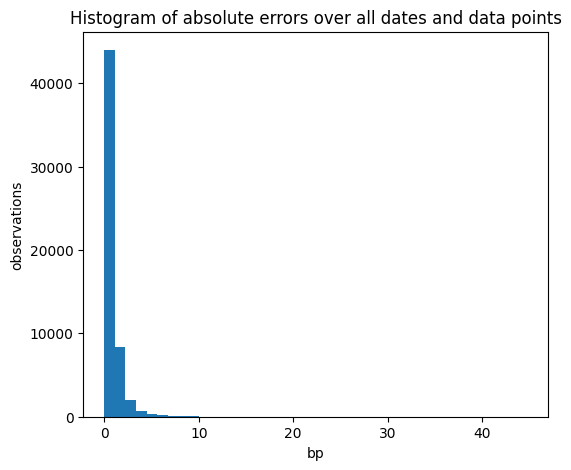

In [5]:
from src.visualization.vol.error_histograms import error_histograms

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
error_histograms(predictions,
                 data_test,
                 save_name=NAME)

As we can see from the graph above, mean Average error is 1.52bp which is significantly less than bid-ask spread for IR vols.

Max error is more than 40bp which is comparable to the bid-ask spread for large (246bp) vol values.

##### Changing of vol cube data when we change z0 values

We can see that this first component (z0) is responsible for skew of vol surface:
    
* When z0 is small (e.g. z0=-3), the vol with short option and swap tenors is smaller than vol with long tenors

* When z0 is large (e.g. z0=3), the vol with short option and swap tenors is larger than the vol with long tenors

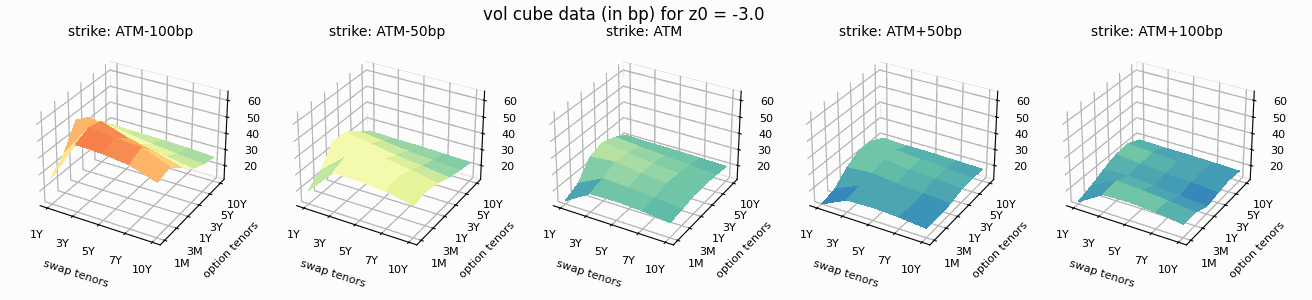

In [6]:
from src.visualization.vol.gif_vol_cube_for_diff_z import gif_vol_cube_for_diff_z

z_idx = 0
strikes = ['ATM-100bp', 'ATM-50bp', 'ATM', 'ATM+50bp', 'ATM+100bp']  # graphs only for these strikes
gif_vol_cube_for_diff_z(vae,
                        normalizer,
                        all_z_vals=[0,0],
                        z_idx=z_idx,
                        x_labels=uniq_swap_tenors,
                        y_labels=uniq_opt_tenors,
                        uniq_strikes=uniq_strikes,
                        strikes=strikes,
                        delete_pngs=False,
                        name='vol_cube_2lat_for_diff_z' + str(z_idx)
                        )

### Changing of vol surface when we change z1 values

We can see that this second component (z1) is responsible for total size of vol values:
    
* When z0 is small (e.g. z0=-3), the vol for all strikes and tenors is large

* When z0 is large (e.g. z0=3), the vol for all strikes and tenors is small

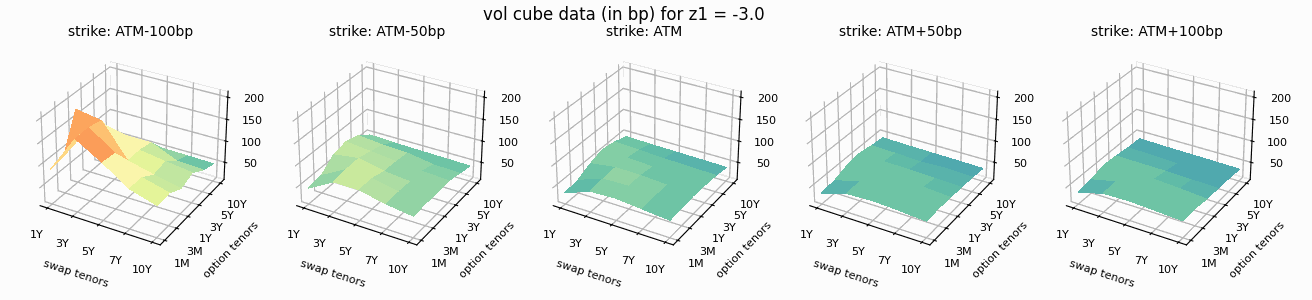

In [7]:
from src.visualization.vol.gif_vol_cube_for_diff_z import gif_vol_cube_for_diff_z

z_idx = 1
strikes = ['ATM-100bp', 'ATM-50bp', 'ATM', 'ATM+50bp', 'ATM+100bp']  # graphs only for these strikes
gif_vol_cube_for_diff_z(vae,
                        normalizer,
                        all_z_vals=[0,0],
                        z_idx=z_idx,
                        x_labels=uniq_swap_tenors,
                        y_labels=uniq_opt_tenors,
                        uniq_strikes=uniq_strikes,
                        strikes=strikes,
                        delete_pngs=False,
                        name='vol_cube_2lat_for_diff_z' + str(z_idx)
                        )

##### "Predictions vs real data" graphs on the test dataset

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


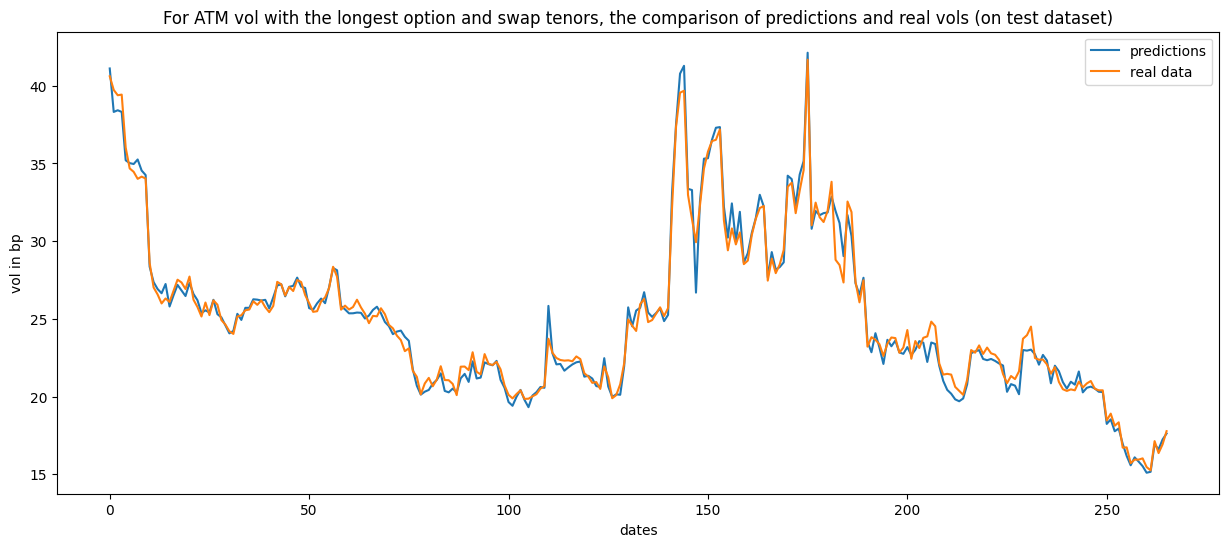

In [8]:
import matplotlib.pyplot as plt
N1 = 5  # option tenor index (10Y)
N2 = 4  # swap tenor index (10Y)
N3 = 3  # strike index (ATM)

predictions = normalizer.denormalize(vae.predict(x=data_norm_test))
plt.figure(figsize=(15,6))
plt.plot(predictions[:, N1, N2, N3], label='predictions')
plt.plot(data_test[:, N1, N2, N3], label='real data')
plt.title('For ATM vol with the longest option and swap tenors, the comparison of predictions and real vols (on test dataset)')
plt.ylabel('vol in bp')
plt.xlabel('dates')
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


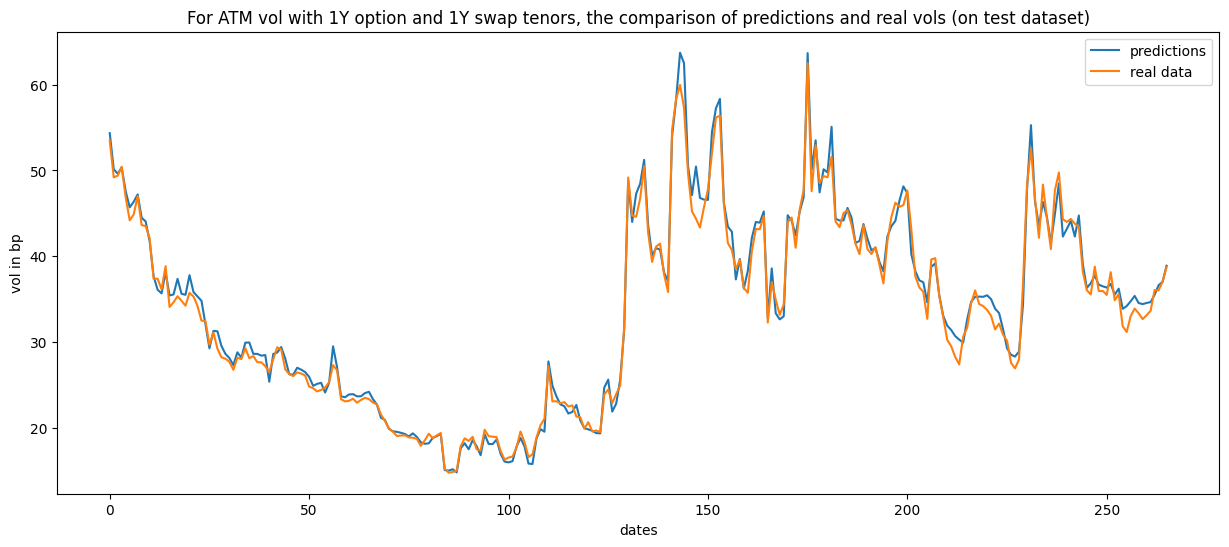

In [9]:
import matplotlib.pyplot as plt
N1 = 2  # option tenor index (1Y)
N2 = 0  # swap tenor index (1Y)
N3 = 3  # strike index (ATM)

predictions = normalizer.denormalize(vae.predict(x=data_norm_test))
plt.figure(figsize=(15,6))
plt.plot(predictions[:, N1, N2, N3], label='predictions')
plt.plot(data_test[:, N1, N2, N3], label='real data')
plt.title('For ATM vol with 1Y option and 1Y swap tenors, the comparison of predictions and real vols (on test dataset)')
plt.ylabel('vol in bp')
plt.xlabel('dates')
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


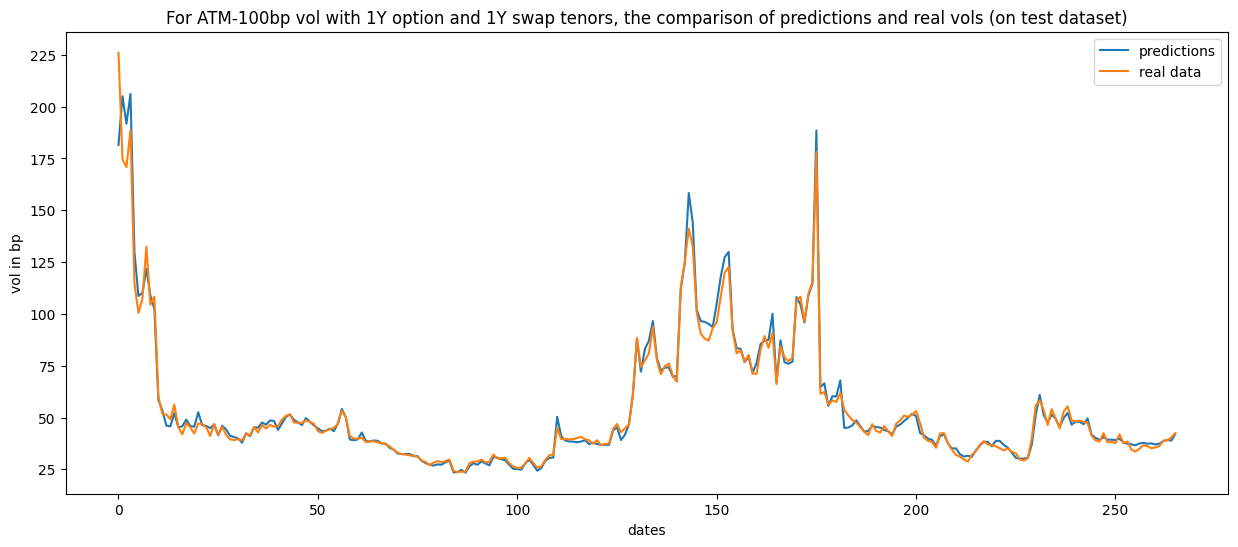

In [10]:
import matplotlib.pyplot as plt
N1 = 2  # option tenor index (1Y)
N2 = 0  # swap tenor index (1Y)
N3 = 0  # strike index (ATM-100bp)

predictions = normalizer.denormalize(vae.predict(x=data_norm_test))
plt.figure(figsize=(15,6))
plt.plot(predictions[:, N1, N2, N3], label='predictions')
plt.plot(data_test[:, N1, N2, N3], label='real data')
plt.title('For ATM-100bp vol with 1Y option and 1Y swap tenors, the comparison of predictions and real vols (on test dataset)')
plt.ylabel('vol in bp')
plt.xlabel('dates')
plt.legend()
plt.show()

##### Error grids for different tenors and strikes on the test dataset

For each option tenor, swap tenor and strike, we calculate MEAN error over all dates

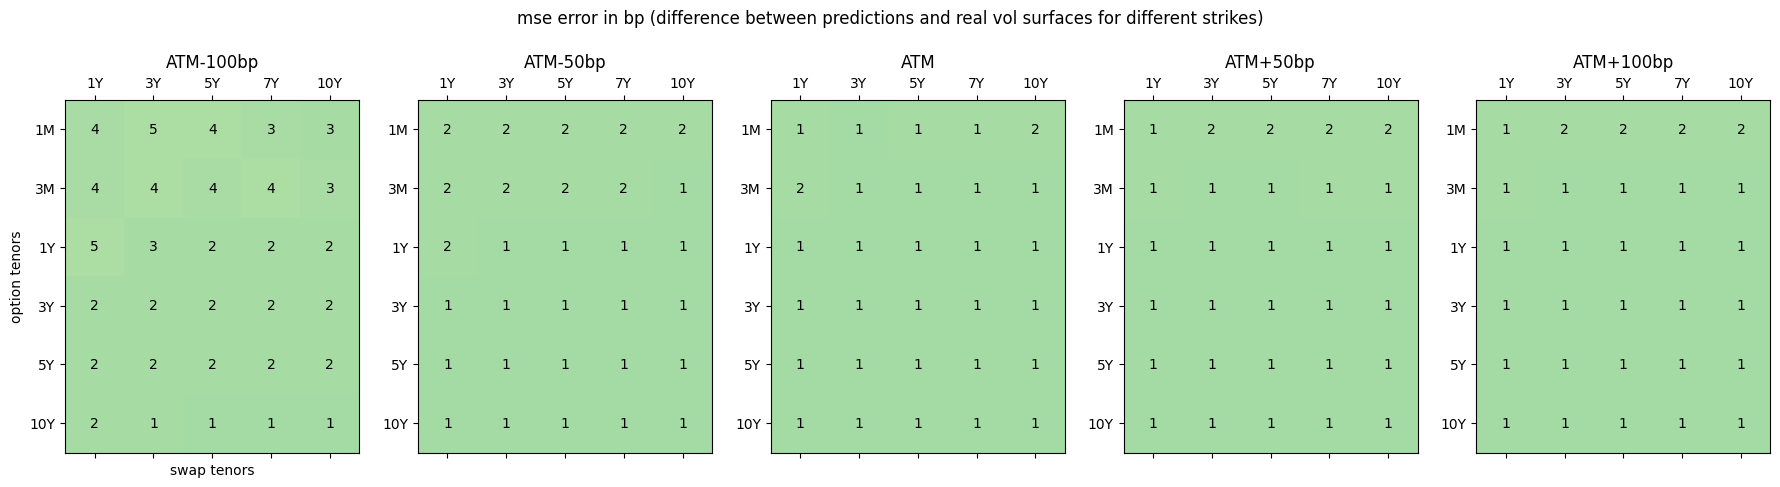

In [11]:
from src.visualization.vol.error_vol_cube_grids import error_vol_cube_grids

strikes = ['ATM-100bp', 'ATM-50bp', 'ATM', 'ATM+50bp', 'ATM+100bp']  # graphs only for these strikes

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
error_vol_cube_grids(predictions,
                     data_test,
                     x_labels=uniq_swap_tenors,
                     y_labels=uniq_opt_tenors,
                     uniq_strikes=uniq_strikes,
                     strikes=strikes,
                     error_type='mse',
                     save_name=NAME
                     )

For each option tenor, swap tenor and strike, we calculate MAX error over all dates

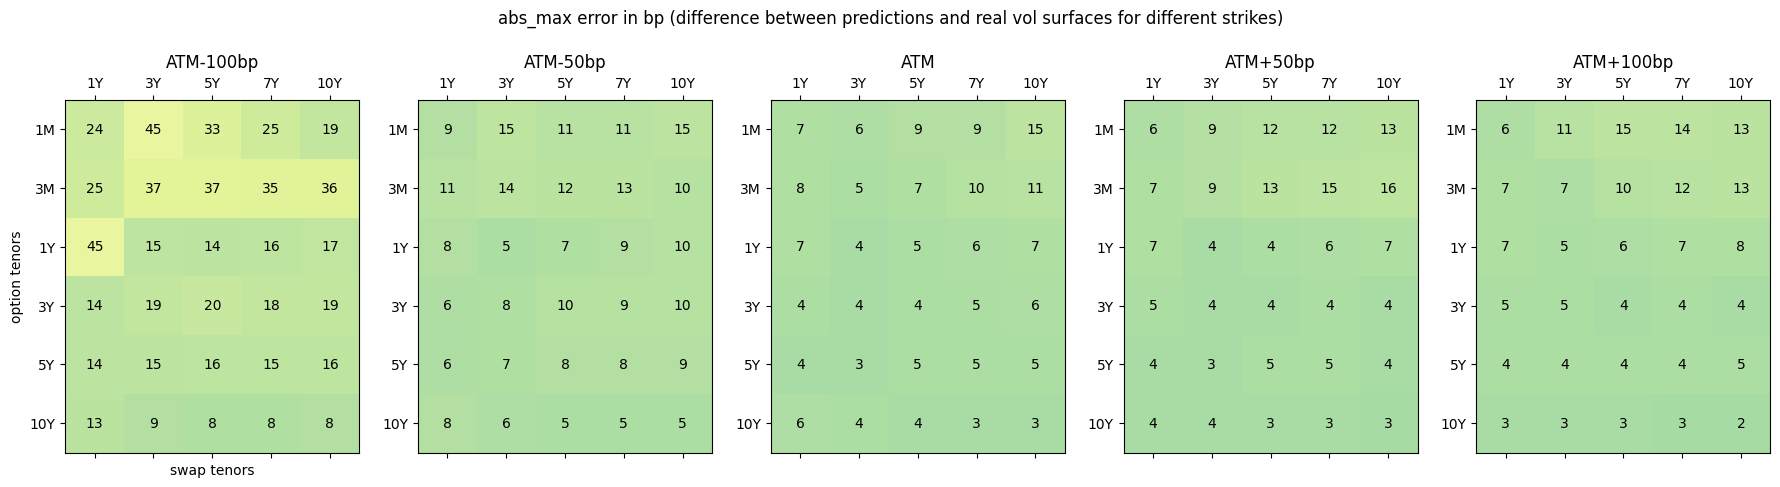

In [12]:
from src.visualization.vol.error_vol_cube_grids import error_vol_cube_grids

strikes = ['ATM-100bp', 'ATM-50bp', 'ATM', 'ATM+50bp', 'ATM+100bp']  # graphs only for these strikes

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
error_vol_cube_grids(predictions,
                     data_test,
                     x_labels=uniq_swap_tenors,
                     y_labels=uniq_opt_tenors,
                     uniq_strikes=uniq_strikes,
                     strikes=strikes,
                     error_type='abs_max',
                     save_name=NAME
                     )